**Imports**

In [2]:
# used for file path manipulations
import os
# reducing TensorFlow logging activity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# used for audio data preprocessing
import librosa

# used for data processing, analysis, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# used for preprocessing, one hot encoding, and implementing the CNN
from tensorflow.image import resize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers

# used for saving result metrics
import json

**Hyper Params.**

In [4]:
hyper = {
  "base_dir": "./gtzan_music_genre_classification_dataset/genres_original",
  "recommend_base_dir": "./recommendor_testing_samples",
  "shape_length": 210,
  "chunk_length_seconds": 5,
  "chunk_overlap": 2,
  "test_size": 0.25,
  "cnn_filter_sizes": [16, 32, 64, 256, 512],
  "cnn_kernel_size": 3,
  "cnn_max_pool_size": 2,
  "cnn_max_pool_stride_length": 2,
  "cnn_dropout": True,
  "cnn_dropout_gap": 3,
  "cnn_dropout_factor": 0.3,
  "cnn_to_flatten_dropout": True,
  "cnn_to_flatten_dropout_factor": 0.3,
  "nn_units": 1200,
  "nn_dropout": True,
  "nn_dropout_factor": 0.45,
  "learning_rate": 0.0001,
  # adjust these hyperparams. as per available system memory to avoid OOM crashes
  "training_epochs": 35,
  "training_batch_size": 8
}

**Feature Engineering**

In [5]:
def dataset_audio_data_extractor(genres, base_dir=hyper["base_dir"], shape_length=hyper["shape_length"]):
  audio_mel_spectogram_data = []
  audio_labels = []

  for i, label in enumerate(genres):
    genre_dir = os.path.join(base_dir, label)

    for song in os.listdir(genre_dir):
      if song.endswith('.wav'):
        file_path = os.path.join(genre_dir, song)

        try:
          time_series_data, sample_rate = librosa.load(file_path, sr=None)

          chunk_length_samples = hyper['chunk_length_seconds'] * sample_rate
          chunk_overlap = hyper['chunk_overlap'] * sample_rate
          num_chunks = int(np.ceil((len(time_series_data) - chunk_length_samples) / (chunk_length_samples - chunk_overlap))) + 1
          for j in range(num_chunks):
            chunk_start = j * (chunk_length_samples - chunk_overlap)
            chunk_end = chunk_start + chunk_length_samples
            chunk = time_series_data[chunk_start:chunk_end]

            chunk_mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
            target_shape = (shape_length, shape_length)
            chunk_mel_spectrogram = resize(np.expand_dims(chunk_mel_spectrogram, axis=-1), target_shape)

            audio_mel_spectogram_data.append(chunk_mel_spectrogram)
            audio_labels.append(i)
        except:
          # this may happen when the audio file codec is corrupted, outdated or incompatible; GTZAN dataset is known to have a few of these flawed files
          # some audio file corruption or incompatibility warnings may be logged still by librosa that can be safely ignored
          continue

  return np.array(audio_mel_spectogram_data), np.array(audio_labels)

genres = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
extracted_data, extracted_labels = dataset_audio_data_extractor(genres)
extracted_labels = to_categorical(extracted_labels, num_classes=len(genres))

print("\n-------------------------------------------------------")
print("Extracted Audio Mel Sepctogram Data:\n", extracted_data)
print(extracted_data.shape)
print("\nOne Hot Encoded Labels:\n", extracted_labels)
print(extracted_labels.shape)

I0000 00:00:1733214479.955402   53339 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/tmp/ipykernel_53339/1812449478.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  time_series_data, sample_rate = librosa.load(file_path, sr=None)
/home/tuf-a15-xan-ubun/anaconda3/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



-------------------------------------------------------
Extracted Audio Mel Sepctogram Data:
 [[[[2.74460554e+00]
   [7.93077111e-01]
   [5.47918379e-02]
   ...
   [7.59918272e-01]
   [3.20767927e+00]
   [8.71823692e+00]]

  [[7.10061073e+00]
   [4.12199211e+00]
   [3.44515777e+00]
   ...
   [3.28920479e+01]
   [4.56263504e+01]
   [1.84253693e+01]]

  [[1.47344265e+01]
   [1.24095879e+01]
   [1.20879087e+01]
   ...
   [8.04361954e+01]
   [1.12157555e+02]
   [3.68347168e+01]]

  ...

  [[3.98395459e-05]
   [9.61155911e-06]
   [1.04285277e-07]
   ...
   [7.08006525e-08]
   [1.47251012e-05]
   [2.09194492e-04]]

  [[3.81519603e-05]
   [9.11747702e-06]
   [3.22713802e-08]
   ...
   [2.91853794e-08]
   [1.46604289e-05]
   [2.08541474e-04]]

  [[3.70575908e-05]
   [8.81666710e-06]
   [8.63598704e-09]
   ...
   [8.91340690e-09]
   [1.46192297e-05]
   [2.08097990e-04]]]


 [[[3.52723670e+00]
   [1.42768013e+00]
   [3.01507425e+00]
   ...
   [2.69630504e+00]
   [1.79253197e+00]
   [1.14339457e

**Dataset Test-Train Split**

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(extracted_data, extracted_labels, test_size=hyper['test_size'], random_state=42) # random_state used to get reproducible output across multiple function calls
print("Training Dataset:\n", X_train)
print(X_train.shape)
print("\nTraining Labels:\n", Y_train)
print(Y_train.shape)
print("\nTesting Dataset:\n", X_test)
print(X_test.shape)
print("\nTesting Labels:\n", Y_test)
print(Y_test.shape)

Training Dataset:
 [[[[1.57424536e+01]
   [2.08473434e+01]
   [2.08593864e+01]
   ...
   [3.58376455e+00]
   [4.64866781e+00]
   [1.63883650e+00]]

  [[1.27966003e+01]
   [1.44078693e+01]
   [1.23281507e+01]
   ...
   [2.20727968e+00]
   [2.75310326e+00]
   [9.80920136e-01]]

  [[8.46514034e+00]
   [5.20989990e+00]
   [2.68336803e-01]
   ...
   [2.62739331e-01]
   [8.62565935e-02]
   [5.63504510e-02]]

  ...

  [[2.00342529e-05]
   [4.91336777e-06]
   [7.75090925e-08]
   ...
   [4.28790344e-07]
   [8.13071983e-06]
   [1.10070847e-04]]

  [[1.91141371e-05]
   [4.64054574e-06]
   [2.70481895e-08]
   ...
   [1.31664052e-07]
   [7.91482489e-06]
   [1.10501052e-04]]

  [[1.85081517e-05]
   [4.46859440e-06]
   [7.73874476e-09]
   ...
   [1.43913086e-08]
   [7.85777684e-06]
   [1.10881592e-04]]]


 [[[9.13626701e-02]
   [5.81243634e-01]
   [6.94059908e-01]
   ...
   [1.05202532e+01]
   [2.24141293e+01]
   [1.01905231e+01]]

  [[1.12092845e-01]
   [4.78294820e-01]
   [6.13639295e-01]
   ...
  

**Classifier Model Construction**

In [7]:
classifier = Sequential()

classifier.add(Conv2D(filters=hyper['cnn_filter_sizes'][0], kernel_size=hyper['cnn_kernel_size'], padding='same', activation='relu', input_shape=X_train[0].shape))
classifier.add(Conv2D(filters=hyper['cnn_filter_sizes'][0], kernel_size=hyper['cnn_kernel_size'], activation='relu'))
classifier.add(MaxPool2D(pool_size=hyper['cnn_max_pool_size'], strides=hyper['cnn_max_pool_stride_length']))

current_layer = 1
for layer_size in hyper['cnn_filter_sizes'][1:]:
  if(hyper['cnn_dropout'] and (current_layer % hyper['cnn_dropout_gap'] == 0)):
    classifier.add(Dropout(hyper['cnn_dropout_factor']))

  classifier.add(Conv2D(filters=layer_size, kernel_size=hyper['cnn_kernel_size'], padding='same', activation='relu'))
  classifier.add(Conv2D(filters=layer_size, kernel_size=hyper['cnn_kernel_size'], activation='relu'))
  classifier.add(MaxPool2D(pool_size=hyper['cnn_max_pool_size'], strides=hyper['cnn_max_pool_stride_length']))

  current_layer += 1

if(hyper['cnn_to_flatten_dropout']):
    classifier.add(Dropout(hyper['cnn_to_flatten_dropout_factor']))

classifier.add(Flatten())
classifier.add(Dense(units=1200, activation='relu'))

if(hyper['nn_dropout']):
    classifier.add(Dropout(hyper['nn_dropout_factor']))

classifier.add(Dense(units=len(genres), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=hyper['learning_rate'])
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

classifier.summary()

/home/tuf-a15-xan-ubun/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 210, 210, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 104, 104, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 102, 102, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 51, 51, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     9,831,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,193,162 (54.14 MB)

 Trainable params: 14,193,162 (54.14 MB)

 Non-trainable params: 0 (0.00 B)

**Classifier Model Training**

In [8]:
train = classifier.fit(X_train, Y_train, epochs=hyper['training_epochs'], batch_size=hyper['training_batch_size'], validation_data=(X_test, Y_test))

# dumping the trained weights and training metics
classifier.save("Trained_Classifier_Weights.keras") # format not supported on Windows Native; use Win WSL2 instead for this to work
with open('training_log.json', 'w') as f:
  json.dump(train.history, f)

Epoch 1/35


I0000 00:00:1733214583.158181   53469 service.cc:148] XLA service 0x7fb3f4004ba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733214583.161392   53469 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
I0000 00:00:1733214583.987492   53469 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/937 ━━━━━━━━━━━━━━━━━━━━ 1:12 78ms/step - accuracy: 0.0312 - loss: 2.4540      

I0000 00:00:1733214591.674366   53469 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


937/937 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.2460 - loss: 2.0608 - val_accuracy: 0.4351 - val_loss: 1.5133
Epoch 2/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.4688 - loss: 1.4744 - val_accuracy: 0.5969 - val_loss: 1.1595
Epoch 3/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.5859 - loss: 1.1792 - val_accuracy: 0.6629 - val_loss: 0.9578
Epoch 4/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.6711 - loss: 0.9344 - val_accuracy: 0.7030 - val_loss: 0.8400
Epoch 5/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.7296 - loss: 0.8008 - val_accuracy: 0.7626 - val_loss: 0.6945
Epoch 6/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.7776 - loss: 0.6570 - val_accuracy: 0.7854 - val_loss: 0.6228
Epoch 7/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.8105 - loss: 0.5506 - val_accuracy: 0.7974 - val_loss: 0.6018
Epoch 8/35
937/937 ━━━━━━━━━━━━━━━━━━━━ 25s 27ms/step - accuracy: 0.8478 - loss: 0.4450 - val_accurac

**Using Pre-Trained Model**

In [9]:
classifier = load_model("Trained_Classifier_Weights.keras")
classifier.summary()

# reloading training metrics
import json
with open("training_log.json",'r') as f:
    training_metrics = json.load(f)

training_metrics = pd.DataFrame.from_dict(training_metrics)
training_metrics.index.name = "epochs"
print("\033[1m Traning Log:\033[0m\n", training_metrics)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 210, 210, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 208, 208, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 104, 104, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 104, 104, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 102, 102, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 51, 51, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     9,831,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,579,488 (162.43 MB)

 Trainable params: 14,193,162 (54.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,386,326 (108.29 MB)

 Traning Log:
         accuracy      loss  val_accuracy  val_loss
epochs                                            
0       0.330352  1.857606      0.435148  1.513254
1       0.503203  1.393900      0.596878  1.159462
2       0.609584  1.126196      0.662930  0.957804
3       0.675120  0.932285      0.702962  0.840030
4       0.733582  0.779321      0.762610  0.694514
5       0.779098  0.652284      0.785428  0.622801
6       0.818473  0.535151      0.797438  0.601787
7       0.850641  0.442469      0.839071  0.523535
8       0.872130  0.372359      0.833867  0.541419
9       0.899760  0.312757      0.827862  0.534283
10      0.917112  0.246937      0.843875  0.515869
11      0.928190  0.207992      0.834267  0.524276
12      0.940870  0.174300      0.861089  0.469818
13      0.937934  0.177332      0.869095  0.468847
14      0.959023  0.129855      0.878303  0.431244
15      0.959690  0.123121      0.857886  0.554097
16      0.954618  0.130658      0.879103  0.423212
17      0.968099

**Classifier Analysis**

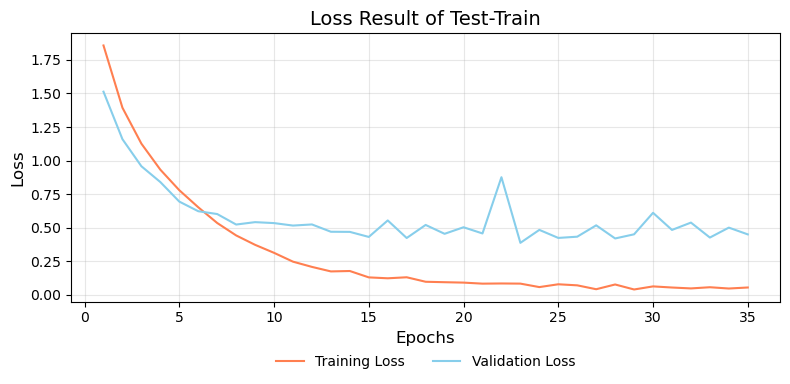

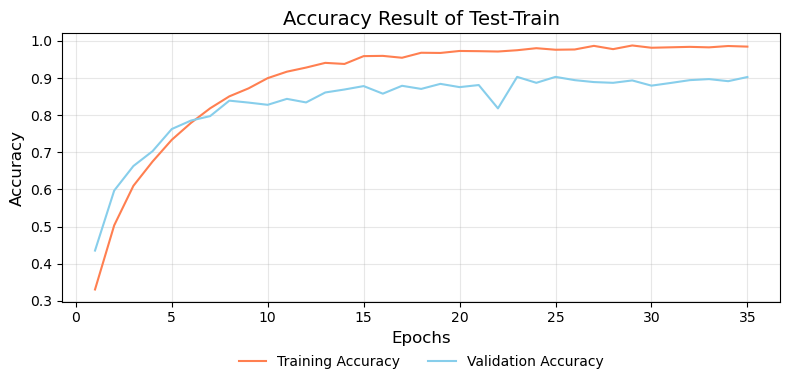


79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


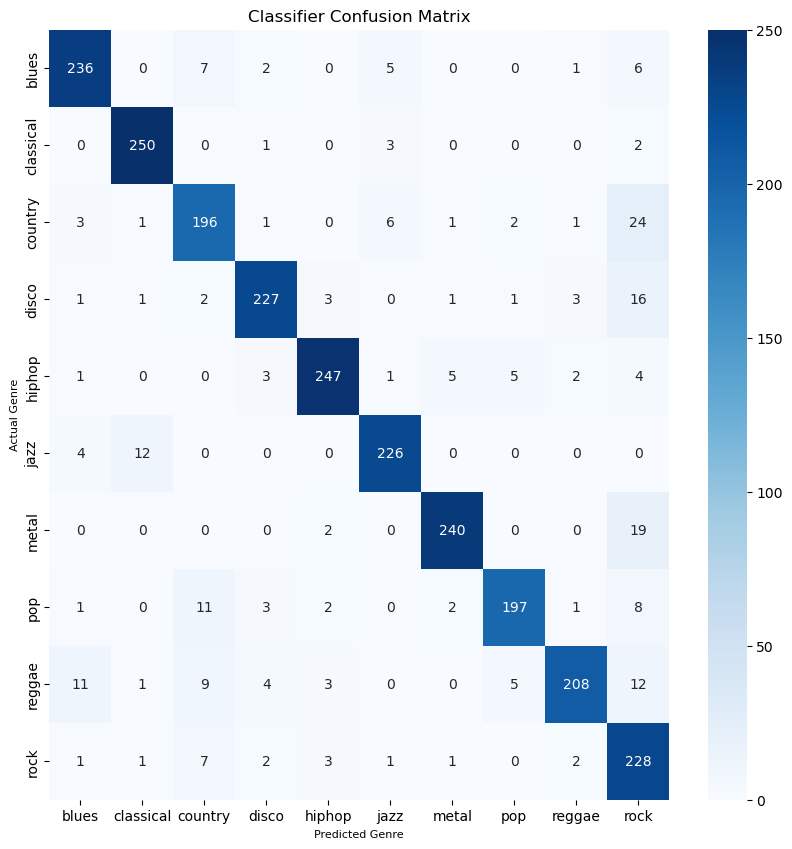

In [10]:
epochs = [i for i in range(1, hyper['training_epochs']+1)]

plt.figure(figsize=(8, 4))
plt.plot(epochs, training_metrics['loss'], label="Training Loss", color='coral', linewidth=1.5)
plt.plot(epochs, training_metrics['val_loss'], label="Validation Loss", color='skyblue', linewidth=1.5)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss Result of Test-Train", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()
print()

plt.figure(figsize=(8, 4))
plt.plot(epochs, training_metrics['accuracy'], label="Training Accuracy", color='coral', linewidth=1.5)
plt.plot(epochs, training_metrics['val_accuracy'], label="Validation Accuracy", color='skyblue', linewidth=1.5)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Result of Test-Train", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)
plt.tight_layout()
plt.show()
print()

Y_prediction = classifier.predict(X_test)
predicted_genres = np.argmax(Y_prediction, axis=1)
actual_genres = np.argmax(Y_test, axis=1)
classifier_confusion_matrix = confusion_matrix(actual_genres, predicted_genres)
plt.figure(figsize=(10, 10))
sns.heatmap(classifier_confusion_matrix, xticklabels=genres, yticklabels=genres, annot=True, annot_kws={"size": 10}, fmt='d', cmap='Blues')
plt.xlabel("Predicted Genre", fontsize=8)
plt.ylabel("Actual Genre", fontsize=8)
plt.title("Classifier Confusion Matrix", fontsize=12)
plt.show()

**Recommender**

In [12]:
song_selection_1 = os.path.join(hyper['recommend_base_dir'], "fma_country_Sorry_for_Hurting_You.mp3")
song_selection_2 = os.path.join(hyper['recommend_base_dir'], "fma_disco_Intro_Funk.mp3")
song_selection_3 = os.path.join(hyper['recommend_base_dir'], "fma_hiphop_Working.mp3")
song_selection_4 = os.path.join(hyper['recommend_base_dir'], "fma_rock_Opening.mp3")
songs = [song_selection_1, song_selection_2, song_selection_3, song_selection_4]

print("Reading Songs:\n")
def predict_song_genre(song):
  audio_mel_spectogram_data = []

  try:
    time_series_data, sample_rate = librosa.load(song, sr=None)

    chunk_length_samples = hyper['chunk_length_seconds'] * sample_rate
    chunk_overlap = hyper['chunk_overlap'] * sample_rate
    num_chunks = int(np.ceil((len(time_series_data) - chunk_length_samples) / (chunk_length_samples - chunk_overlap))) + 1
    for i in range(num_chunks):
      chunk_start = i * (chunk_length_samples - chunk_overlap)
      chunk_end = chunk_start + chunk_length_samples
      chunk = time_series_data[chunk_start:chunk_end]

      chunk_mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
      target_shape = (hyper["shape_length"], hyper["shape_length"])
      chunk_mel_spectrogram = resize(np.expand_dims(chunk_mel_spectrogram, axis=-1), target_shape)

      audio_mel_spectogram_data.append(chunk_mel_spectrogram)
  except:
    print("Corrupted/Incompatible audio file!")
    return None

  extracted_data = np.array(audio_mel_spectogram_data)

  Y_prediction = classifier.predict(extracted_data)
  predicted_chunk_genres = np.argmax(Y_prediction, axis=1)
  predicted_chunk_genres_unique, freq = np.unique(predicted_chunk_genres, return_counts=True)
  most_predicted_genre = predicted_chunk_genres_unique[freq == np.max(freq)]
  return genres[most_predicted_genre[0]]

predicted_song_genres = []
genre_error = False
for song in songs:
  genre = predict_song_genre(song)
  if(not genre):
    # print("File:", song, "\n Is corrupted/incompatible, ensure the file path is correct or try using another one!")
    genre_error = True
    break

  predicted_song_genres.append(genre)

if(not genre_error):
  predicted_song_genres = np.unique(np.array(predicted_song_genres))
  print("\nSong Recommendations (from GTZAN database):")
  for genre in predicted_song_genres:
    choices = np.random.rand(4)
    choices = [np.ceil(x * 99) for x in choices]

    for i in choices:
      if(i >= 0 and i <= 9):
        index = str(int(i))
        index = "0" + index
      else:
        index = str(int(i))

      file_name = genre + ".000" + index + ".wav"
      file_name = os.path.join(hyper["base_dir"], file_name)
      print(file_name, "(based on " + genre + " genre)")

Reading Songs:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

Song Recommendations (from GTZAN database):
./gtzan_music_genre_classification_dataset/genres_original/country.00061.wav (based on country genre)
./gtzan_music_genre_classification_dataset/genres_original/country.00034.wav (based on country genre)
./gtzan_music_genre_classification_dataset/genres_original/country.00012.wav (based on country genre)
./gtzan_music_genre_classification_dataset/genres_original/country.00081.wav (based on country genre)
./gtzan_music_genre_classification_dataset/genres_original/disco.00054.wav (based on disco genre)
./gtzan_music_genre_classification_dataset/genres_original/disco.00088.wav (based on disco genre)
./gtzan_music_genre_classification_dataset/genres_original/disco.00027.wav (based on disco genre)
./gtzan_music_genre_classification_dataset/genres_original/disco.00004.wav (based on

**Misc.**

Shape: (128, 1293)


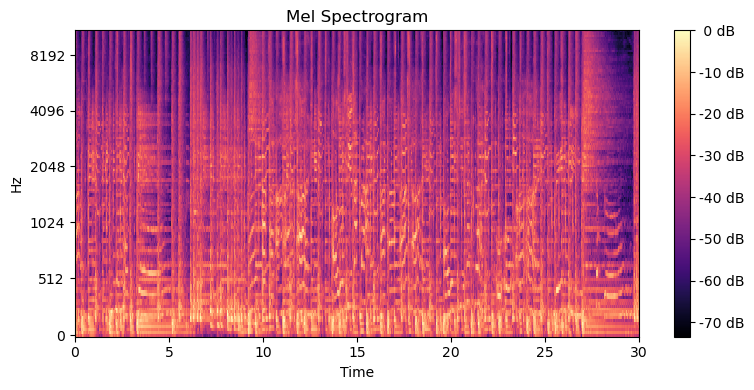

Shape: (128, 216)


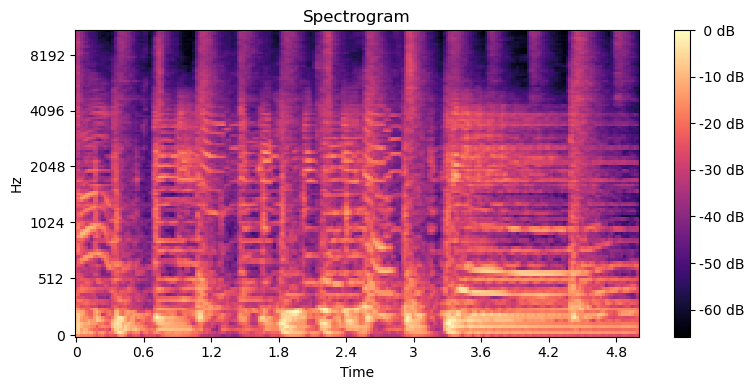

In [13]:
# Mel Spectogram of a 30 sec dataset sample
time_series_data, sample_rate = librosa.load(os.path.join(hyper["base_dir"], "rock", "rock.00042.wav"), sr=None)
spectrogram = librosa.feature.melspectrogram(y=time_series_data, sr=sample_rate)
print("Shape:", spectrogram.shape)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(8, 4))
librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%2.0f dB')
plt.title("Mel Spectrogram")
plt.tight_layout()
plt.show()

# Mel Spectogram of a 5 sec dataset sample
time_series_data, sample_rate = librosa.load(os.path.join(hyper["base_dir"], "rock", "rock.00042.wav"), sr=None)
chunk = time_series_data[0:110249]
spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
print("Shape:", spectrogram.shape)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(8,4))
librosa.display.specshow(spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%2.0f dB')
plt.title("Spectrogram")
plt.tight_layout()
plt.show()